In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from scipy import io
import matplotlib.pyplot as plt
import math

In [33]:
def simpleClassifier(X, y, weights):
    theta_max = np.zeros(X.shape[1],dtype=np.int32)
    theta_min = np.zeros(X.shape[1],dtype=np.int32)
    threshold_ = np.zeros(X.shape[1],dtype=np.int32)
    threshold = np.zeros(X.shape[1])
    
    classification_error = np.zeros(X.shape[1])
    sign = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        temp = np.zeros(X.shape[0])
        indices = np.argsort(X[:,i])
        sorted_X = np.sort(X[:,i])
        sorted_targets = y[indices]
        sorted_weights = weights[indices]
        for j in range(X.shape[0]):
            temp[j] = np.sum(sorted_weights[0:j+1] * sorted_targets[0:j+1])
        theta_max[i] = np.max(temp)
        theta_min[i] = np.min(temp)
    
        if(abs(theta_max[i])>abs(theta_min[i])):
            threshold_[i] = np.argmax(temp)
            sign[i] = 1
        else:
            threshold_[i] = np.argmin(temp)
            sign[i] = -1
        threshold[i] = sorted_X.flatten()[threshold_[i]]
       

    for i in range(threshold.shape[0]):
        hypo = np.zeros(X.shape[0])
        hypo[sign[i]*X[:,i] <= sign[i]*threshold[i]] = 1
        hypo[hypo==0] = -1
        indicator = hypo!=y.flatten()
        indicator = indicator.astype(int)
        #print((np.matmul(weights.transpose(),indicator)/np.sum(weights)).shape)
        classification_error[i] = np.matmul(weights.transpose(),indicator)/np.sum(weights)
    
    dimension = np.argmin(classification_error)
    parity_sign = sign[dimension]
    threshold_value = threshold[dimension]
    epsilon = classification_error[dimension]
    alpha = math.log((1-epsilon)/epsilon)
    hypothesis = np.zeros(X.shape[0])
    hypothesis[sign[dimension]*X[:,dimension] <= sign[dimension]*threshold[dimension]] = 1
    hypothesis[hypothesis==0] = -1
    indicator_ = hypothesis!=y.flatten()
    indicator_ = indicator_.astype(int)

    updated_weights = np.multiply(weights.flatten(),np.exp(np.multiply(alpha,indicator_)))
    return dimension, threshold_value, updated_weights, alpha

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_(X, Y, j, theta, text):

    # Define some helper vars for plotting
    number = len(Y)
    xmin = min(X[:, 0])
    xmax = max(X[:, 0])
    ymin = min(X[:, 1])
    ymax = max(X[:, 1])
    
    # Plot the classifier together with the data
    plt.subplot()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(text)
    plt.axis([xmin, xmax, ymin, ymax])

    plt.plot(X[:, 0:1][Y == 1], X[:, 1:2][Y == 1], c='b', marker='x', linestyle='none', markersize=5)
    plt.plot(X[:, 0:1][Y == -1], X[:, 1:2][Y == -1], c='r', marker='o', linestyle='none', markersize=5,
             fillstyle='none')

    if j == 0:  # plot
        a = np.arange(ymin, ymax, (ymax-ymin)/number)
        plt.plot(np.ones(len(a))*theta, a, 'r-')
    else:
        a = np.arange(xmin, xmax, (xmax-xmin)/number)
        plt.plot(a, np.ones(len(a))*theta, 'r-')


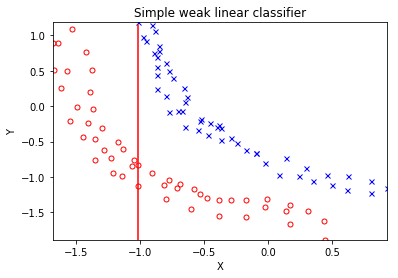

-1.0161290322580643
0


In [35]:
syn = io.loadmat('q1_adaboost_python/synthetic')  # ... or load existing dataset
X = syn['X']
Y = syn['Y']
# b) Simple weak classifier training
initial_weights_1 = np.zeros((X.shape[0],1))
initial_weights_1[:] = 1/X.shape[0]

j_1, theta_1,updated_weights_1, a_1 = simpleClassifier(X, Y, initial_weights_1)
plt.subplot()
plot_(X, Y, j_1, theta_1, 'Simple weak linear classifier')
plt.show()
print(theta_1)
print(j_1)

In [36]:
def adaboostSimple(X, Y, K, nSamples):
    para = []
    alphak = []
    
    initial_weights = np.zeros((X.shape[0],1))
    initial_weights[:] = 1/X.shape[0]
    
    random_numbers = np.random.choice(X.shape[0], nSamples, replace=False, p=initial_weights.flatten()/np.sum(initial_weights))
    
    X_random = X[random_numbers]
    Y_random = Y[random_numbers]
    initial_weights_random = initial_weights[random_numbers]
    j, theta,updated_weights, a = simpleClassifier(X_random, Y_random, initial_weights_random)
    initial_weights[random_numbers] = updated_weights.reshape(nSamples,1)
    updated_weights_2 = initial_weights
    
    para = np.c_[[j,theta]].transpose()
    alphak = np.append(alphak,a)
    
    for i in range(1,K):
        if(a==0):
            break
        random_numbers = np.random.choice(X.shape[0], nSamples, replace=False, p=updated_weights_2.flatten()/np.sum(updated_weights_2))
        
        X_random = X[random_numbers]
        Y_random = Y[random_numbers]
        initial_weights_random = updated_weights_2[random_numbers]
        j, theta,updated_weights, a = simpleClassifier(X_random, Y_random, initial_weights_random)
        updated_weights_2[random_numbers] = updated_weights.reshape(nSamples,1)
        
        para = np.r_[para,[[j,theta]]]
        alphak = np.append(alphak,a)
    return [para,alphak]

In [37]:
def eval_adaBoost_simpleClassifier(X, alphaK, para):
    hypothesis_all = np.zeros((X.shape[0],alphaK.shape[0]))
    for i in range(hypothesis_all.shape[1]):
        hypothesis_all[X[:,(para[i,0]).astype(int)] > [para[i,1]],i] = 1
        hypothesis_all[hypothesis_all[:,i]!=1,i] = -1
    result = np.matmul(hypothesis_all,alphaK)
    return [np.sign(result),result]

In [41]:
parameters,classifier_weights = adaboostSimple(X,Y,200, 20)
output, outputvals = eval_adaBoost_simpleClassifier(X,classifier_weights,parameters)
print(np.sum(output!=Y.flatten())/X.shape[0])

0.04


In [8]:

def generate_grid(X):
    xmax = max(X[:,0])+1
    xmin = min(X[:,0])-1
    ymax = max(X[:,1])+1
    ymin = min(X[:,1])-1

    xmax = max(xmax, ymax)
    ymax = max(abs(ymin), abs(xmin))
    xmax = max(xmax, ymax)
    x = np.arange(-xmax, xmax, .05)
    y = np.arange(-xmax, xmax, .05)
    
    X_grid, Y_grid = np.meshgrid(x,y)
    return [X_grid, Y_grid, x, y]

In [9]:
def plot_decision_surface(X_, Y_, X, Y, tit):
    # Inputs
    #   X_ : grid data points
    #   Y_ : grid predicted labels
    #   X  : train data points
    #   Y  : train ground truth labels

    plt.subplot()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(tit)
    plt.axis([min(X_[:, 0]), max(X_[:, 0]), min(X_[:, 1]), max(X_[:, 1])])

    plt.plot(X_[Y_ == 1][:, 0], X_[Y_ == 1][:, 1], c='cyan', marker=(8, 2, 0), linewidth=0.5)
    plt.plot(X_[Y_ == -1][:, 0], X_[Y_ == -1][:, 1], c='yellow', marker=(8, 2, 0), linewidth=0.5)

    plt.plot(X[:, 0:1][Y == 1], X[:, 1:2][Y == 1], c='b', marker='x', linestyle='none', markersize=5)
    plt.plot(X[:, 0:1][Y == -1], X[:, 1:2][Y == -1], c='r', marker='o', linestyle='none', markersize=5,
             fillstyle='none')
    
    plt.show()


In [10]:
import matplotlib.pyplot as plt

def plot_logits(logits_r, tit):
    plt.subplot()
    plt.imshow(logits_r, origin = 'lower')

    plt.text(41, 70, r'$\leftarrow$ Decision Boundary', fontsize = 16)
    plt.text(48, 60, '"Zero-Crossing"', fontsize = 16)

    plt.colorbar()
    plt.contour(logits_r, 0, linewidths = 3, colors = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(tit)
    plt.show()


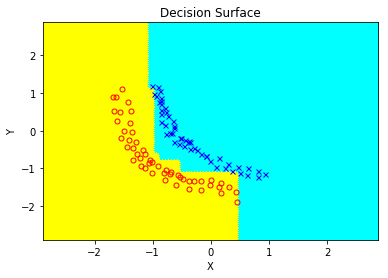

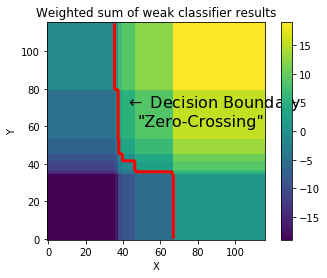

In [11]:

kMax = 200          # Number of weak classifiers
nSamples = 40
# Number of random samples to train each classifier

# Compute parameters of K classifiers and the voting weight for each classifier
para,alphaK = adaboostSimple(X, Y, kMax, nSamples)

# Sample test data from a regular grid to illustrate the decision regions
X_grid, Y_grid, x, y = generate_grid(X)
X_ = np.vstack((X_grid.reshape((-1,)), Y_grid.reshape((-1,)))).T

# Compute discrete class predictions and continuous class probabilities
classLabels, logits = eval_adaBoost_simpleClassifier(X_, alphaK, para)

# Show decision surface
plot_decision_surface(X_, classLabels, X, Y, 'Decision Surface')

# Visualize logits
logits_r = np.reshape(logits, (len(x), len(y)))  # reshape into original shape
plot_logits(logits_r, 'Weighted sum of weak classifier results')



In [12]:
def find_error(X_test,Y_test,alphak,para):
    output_result_sgn, output_result = eval_adaBoost_simpleClassifier(X_test,alphak,para)
    return (np.sum(output_result_sgn!=Y_test.flatten())/X_test.shape[0])

In [13]:
def adaboostCross(X, Y, K, nSamples, percent):
    para = []
    alphak = []
    number_of_samples = int(X.shape[0]*percent)
    train_indices = np.random.choice(X.shape[0], number_of_samples,replace=False)
    X_train = X[train_indices]
    Y_train = Y[train_indices] 
    one_two_three_four = np.arange(X.shape[0])
   
    X_CV = X[np.setdiff1d(one_two_three_four,train_indices.flatten())]
    Y_CV = Y[np.setdiff1d(one_two_three_four,train_indices.flatten())]
   
    error = np.zeros((K,1))

    initial_weights = np.zeros((number_of_samples,1))
    initial_weights[:] = 1/number_of_samples
    
    random_numbers = np.random.choice(number_of_samples, nSamples, replace=False, p=initial_weights.flatten()/np.sum(initial_weights))
    
    X_random = X_train[random_numbers]
    Y_random = Y_train[random_numbers]
    initial_weights_random = initial_weights[random_numbers]
    j, theta,updated_weights, a = simpleClassifier(X_random, Y_random, initial_weights_random)
    initial_weights[random_numbers] = updated_weights.reshape(nSamples,1)
    updated_weights_2 = initial_weights
    
    para = np.c_[[j,theta]].transpose()
    alphak = np.append(alphak,a)
    
    error[0] = find_error(X_CV,Y_CV,alphak,para)
    
    for i in range(1,K):
        if(a==0):
            break
        random_numbers = np.random.choice(number_of_samples, nSamples, replace=False, p=updated_weights_2.flatten()/np.sum(updated_weights_2))
        
        X_random = X_train[random_numbers]
        Y_random = Y_train[random_numbers]
        initial_weights_random = updated_weights_2[random_numbers]
        j, theta,updated_weights, a = simpleClassifier(X_random, Y_random, initial_weights_random)
        updated_weights_2[random_numbers] = updated_weights.reshape(nSamples,1)
        
        para = np.r_[para,[[j,theta]]]
        alphak = np.append(alphak,a)
        
        error[i] = find_error(X_CV,Y_CV,alphak,para)
        
    return [para,alphak,X_CV,Y_CV,error]

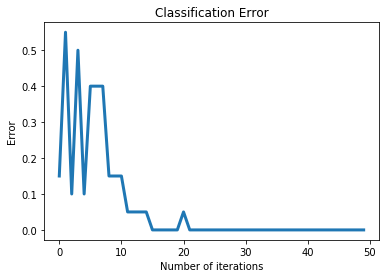

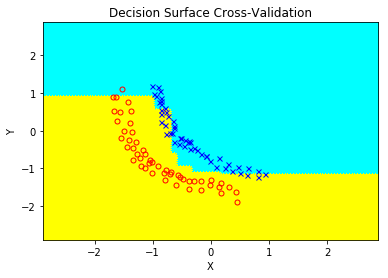

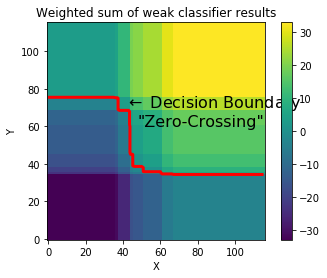

In [14]:
kMax = 50          # Number of weak classifiers
nSamples = 30      # Number of random samples to train each classifier
percent = 0.8      # Percentage of train data

para, alphaK, testX, testY, error = adaboostCross(X, Y, kMax, nSamples, percent)

# Plot the classification error
plt.subplot()
plt.plot(error, linewidth = 3)
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.title('Classification Error')
plt.show()

# Sample data from a regular grid to illustrate the decision regions
X_grid, Y_grid, x, y = generate_grid(X)
X_ = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

# Apply classifier to grid-sampled data
classLabels, logits = eval_adaBoost_simpleClassifier(X_, alphaK, para)

# Show decision surface
plot_decision_surface(X_, classLabels, X, Y, 'Decision Surface Cross-Validation')

# Visualize logits
logits_r = np.reshape(logits, (len(x), len(y)))  # reshape into original shape
plot_logits(logits_r, 'Weighted sum of weak classifier results')

# <center> Least Square Classifier </center>

In [46]:
def leastSquares(data_ls, label_ls, weight_for_data):
    # Sum of squared error shoud be minimized
    #
    # INPUT:
    # data        : Training inputs  (num_samples x dim)
    # label       : Training targets (num_samples x 1)
    #
    # OUTPUT:
    # weights     : weights   (dim x 1)
    # bias        : bias term (scalar)

    #####Start Subtask 1a#####
    # Extend each datapoint x as [1, x]
    # (Trick to avoid modeling the bias term explicitly)
    num_samples_ls = len(data_ls)
    data_ls = np.concatenate((np.ones((num_samples_ls, 1)), data_ls), axis=1)  # before: (38x2), now: (38x3)

    # Take the pseudo inverse
    weight_ls = np.linalg.lstsq((data_ls.T.dot(data_ls)),data_ls.T)[0].dot(label_ls) # inv(A)*b = A\b shape: (3, 1)  # Form the output
    
    hypo_leastsquare = np.matmul(data_ls,weight_ls)
    hypo_leastsquare = np.sign(hypo_leastsquare)
    hypo_error = hypo_leastsquare!=label_ls
    
    epsilon_leastsquare = np.matmul(weight_for_data.transpose(),hypo_error)/np.sum(weight_for_data)
    if(epsilon_leastsquare == 0):
        epsilon_leastsquare += 0.00001
    alpha_ls = math.log((1-epsilon_leastsquare)/epsilon_leastsquare) 
    
    updated_weights_ls = np.multiply(weight_for_data,np.exp(np.multiply(alpha_ls,hypo_error)))
    
    #bias = weight[0]  # get bias
    #weight = weight[1:]  # get weights
    
    
    #####End Subtask#####
    return weight_ls,alpha_ls,updated_weights_ls


In [47]:
def eval_adaBoost_leastSquare(X_data_ls, alphaK_ls, para_ls):
    X_data_ls = np.concatenate((np.ones((X_data_ls.shape[0], 1)), X_data_ls), axis=1)  # before: (38x2), now: (38x3)
    hypothesis_all_ls = np.zeros((X_data_ls.shape[0],alphaK_ls.shape[0]))
    for i in range(hypothesis_all_ls.shape[1]):
        #print(np.matmul(X_data_ls,para_ls[i,:,:]))
        hypothesis_all_ls[:,i] = np.sign(np.matmul(X_data_ls,para_ls[i,:,:])).flatten()
    result_ls = np.matmul(hypothesis_all_ls,alphaK_ls)
    #print(result_ls)
    #print(alphaK_ls)
    return [np.sign(result_ls),result_ls]

In [48]:
def find_error_LSLC(X_ls_error,Y_ls_error,alphak_ls_error,para_ls_error):
    #print(alphak_ls_error)
    output_result_sgn_ls, output_result_ls = eval_adaBoost_leastSquare(X_ls_error,alphak_ls_error,para_ls_error)
    return (np.sum(output_result_sgn_ls!=Y_ls_error.flatten())/X_ls_error.shape[0])

In [49]:
def adaboostLSLC(X_ls, Y_ls, K_ls, nSamples_ls):
 # Adaboost with least squares linear classifier as weak # classifier
# for a D-dim dataset #
# INPUT:
# X : the dataset (numSamples x numDim)
# Y : labeling (numSamples x 1)
# K : number of weak classifiers (iteration number
 # of Adaboost) (scalar)
 # nSamples : number of data which are weighted sampled
 # (scalar)
 #
 # OUTPUT:
 # alphaK : voting weights (K x 1)
 # para : parameters of least square classifier (K x 3)
 # For a D-dim dataset each least square classifier has D+1
 # parameters w0, w1, w2........wD
    
    
    para_ls = []
    alphak_ls = []
    
    initial_weights_ls = np.zeros((X_ls.shape[0],1))
    initial_weights_ls[:] = 1/X_ls.shape[0]
    random_numbers_ls = np.random.choice(X_ls.shape[0], nSamples_ls, replace=False, p=initial_weights_ls.flatten()/np.sum(initial_weights_ls))
    X_random_ls = X_ls[random_numbers_ls]
    Y_random_ls = Y_ls[random_numbers_ls]
    initial_weights_random_ls = initial_weights_ls[random_numbers_ls]
    weight_ls,a_ls,updated_weights_ls = leastSquares(X_random_ls, Y_random_ls, initial_weights_random_ls)
    
    initial_weights_ls[random_numbers_ls] = updated_weights_ls.reshape(nSamples_ls,1)
    updated_weights_2_ls = initial_weights_ls
    
    para_ls = np.c_[[weight_ls]].transpose()
    alphak_ls = np.append(alphak_ls,a_ls)
    for i in range(1,K_ls):
        if(a_ls==0):
            break
        random_numbers_ls = np.random.choice(X_ls.shape[0], nSamples_ls, replace=False, p=updated_weights_2_ls.flatten()/np.sum(updated_weights_2_ls))
        X_random_ls = X_ls[random_numbers_ls]
        Y_random_ls = Y_ls[random_numbers_ls]
        initial_weights_random_ls = updated_weights_2_ls[random_numbers_ls]
        weight_ls,a_ls,updated_weights_ls = leastSquares(X_random_ls, Y_random_ls, initial_weights_random_ls)
        updated_weights_2_ls[random_numbers_ls] = updated_weights_ls.reshape(nSamples_ls,1)
    
        para_ls = np.r_[para_ls,[weight_ls]]
        alphak_ls = np.append(alphak_ls,a_ls)

    
    return [alphak_ls, para_ls]

/Users/shubham/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[-7.28346779 -7.28346779 -7.28346779 ...  7.28346779  7.28346779
  7.28346779]


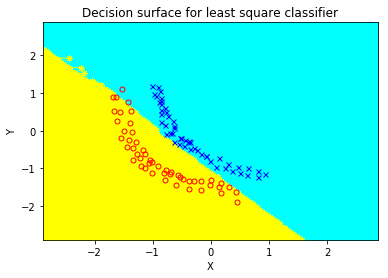

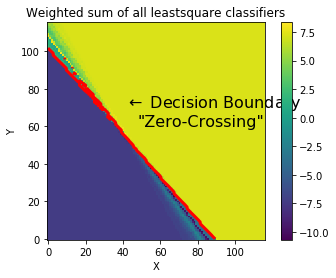

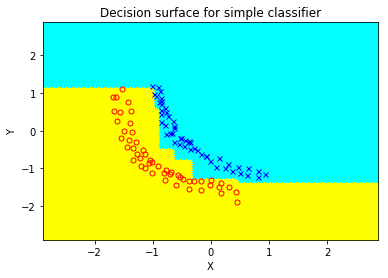

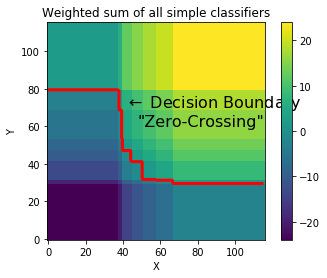

In [18]:

# What is the influence of these parameters?
kMax = 500         # Number of weak classifiers
nSamples = 40      # Number of random samples to train each classifier

# Train both classifiers
alphaK_ls_, para_ls_ = adaboostLSLC(X, Y, kMax, nSamples)
para_sc, alphaK_sc = adaboostSimple(X, Y, kMax, nSamples)

# Sample data from a regular grid to illustrate the decision regions
X_grid, Y_grid, x, y = generate_grid(X)
X_ = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

# Apply both classifiers on grid data
classLabels_ls, logits_ls = eval_adaBoost_leastSquare(X_, alphaK_ls_, para_ls_)
classLabels_sc, logits_sc = eval_adaBoost_simpleClassifier(X_, alphaK_sc, para_sc)

# Plot least-square classifier
plot_decision_surface(X_, classLabels_ls, X, Y, 'Decision surface for least square classifier')
logits_ls_r = np.reshape(logits_ls, (len(x), len(y)))
plot_logits(logits_ls_r, 'Weighted sum of all leastsquare classifiers')

# Plot simple classifier
plot_decision_surface(X_, classLabels_sc, X, Y, 'Decision surface for simple classifier')
logits_sc_r = np.reshape(logits_sc, (len(x), len(y)))
plot_logits(logits_sc_r, 'Weighted sum of all simple classifiers')



In [61]:
def adaboostUSPS(X_usps, Y_usps, K_usps, nSamples_usps, percent_usps):
 # Adaboost with least squares linear classifier as weak
 # classifier on USPS data
 # for a high dimensional dataset
 #
 # INPUT:
 # X : the dataset (numSamples x numDim)
 # Y : labeling (numSamples x 1)
 # K : number of weak classifiers (scalar)
 # nSamples : number of data points obtained by weighted
 # sampling (scalar)
 #
 # OUTPUT:
 # alphaK : voting weights (1 x k)
 # para : parameters of simple classifier (K x (D+1))
 # For a D-dim dataset each simple classifier has
 # D+1 parameters
 # error : training error (1 x k)
    
    random_usps_train = np.random.choice(X_usps.shape[0],int(X_usps.shape[0]*percent_usps), replace=False)
    usps_X_train = X_usps[random_usps_train]
    usps_Y_train = Y_usps[random_usps_train]
    random_usps_CV = np.setdiff1d(np.arange(10000),random_usps_train.flatten())
    usps_X_CV = X_usps[random_usps_CV]
    usps_Y_CV = Y_usps[random_usps_CV]
    
    
    para_ls_usps = []
    alphak_ls_usps = []
    error_usps = np.zeros((K_usps))
    initial_weights_ls_usps = np.zeros((usps_X_train.shape[0],1))
    initial_weights_ls_usps[:] = 1/usps_X_train.shape[0]
    
    
    random_numbers_usps = np.random.choice(usps_X_train.shape[0], nSamples_usps, replace=False, p=initial_weights_ls_usps.flatten()/np.sum(initial_weights_ls_usps))
    X_random_ls_usps = usps_X_train[random_numbers_usps]
    Y_random_ls_usps = usps_Y_train[random_numbers_usps]
    initial_weights_random_ls_usps = initial_weights_ls_usps[random_numbers_usps]
    weight_usps,a_usps,updated_weights_usps = leastSquares(X_random_ls_usps, Y_random_ls_usps, initial_weights_random_ls_usps)
    
    initial_weights_ls_usps[random_numbers_usps] = updated_weights_usps.reshape(nSamples_usps,1)
    updated_weights_2_ls_usps = initial_weights_ls_usps
    
    para_ls_usps = np.c_[[weight_usps]].transpose()
    alphak_ls_usps = np.append(alphak_ls_usps,a_usps)
    
    error_usps[0] = find_error_LSLC(usps_X_CV,usps_Y_CV,alphak_ls_usps,para_ls_usps)
    #print(error_usps[0])
    for i in range(1,K_usps):
        if(a_usps==0):
            break
        random_numbers_usps = np.random.choice(usps_X_train.shape[0], nSamples_usps, replace=False, p=updated_weights_2_ls_usps.flatten()/np.sum(updated_weights_2_ls_usps))
        X_random_ls_usps = usps_X_train[random_numbers_usps]
        Y_random_ls_usps = usps_Y_train[random_numbers_usps]
        initial_weights_random_ls_usps = updated_weights_2_ls_usps[random_numbers_usps]
        weight_usps,a_usps,updated_weights_usps = leastSquares(X_random_ls_usps, Y_random_ls_usps, initial_weights_random_ls_usps)
        updated_weights_2_ls_usps[random_numbers_usps] = updated_weights_usps.reshape(nSamples_usps,1)
        
        para_ls_usps = np.r_[para_ls_usps,[weight_usps]]
        alphak_ls_usps = np.append(alphak_ls_usps,a_usps)
        error_usps[i] = find_error_LSLC(usps_X_CV,usps_Y_CV,alphak_ls_usps,para_ls_usps)
        
    return [alphak_ls_usps, para_ls_usps, error_usps]

Running adaboostUSPS...


/Users/shubham/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


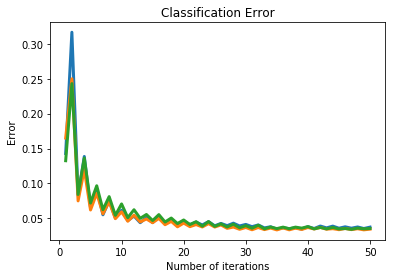

In [71]:

usps = io.loadmat('q1_adaboost_python/usps')   # Load USPS dataset
X = usps['X']
Y = usps['Y']
kMax = 50       # Number of weak classifiers
nSamples = 200  # Number of random samples to train each classifier
percent = 0.1   # Percentage of train data

iter = 3                    # How many times do we want to run it?
errors = np.ndarray((iter, kMax))  # Placeholder for errors
print('Running adaboostUSPS...')
for i in range(iter):            # Run it multiple times
    alphaK, para, error = adaboostUSPS(X, Y, kMax, nSamples, percent)
    errors[i, :] = error


# Plot error over iterations for multiple runs
plt.subplot()
for i in range(iter):
    plt.plot(np.arange(1, kMax+1), errors[i, :], linewidth=3)
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.title('Classification Error')
plt.show()
